In [185]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from mpl_toolkits.axes_grid1 import make_axes_locatable
from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [186]:
device = torch.device("cuda")

In [ ]:
class BinarizeTransform:
    """
    A class to binarize the input MNIST data.
    """
    def __call__(self, img):
        # Values are between 0 and 1 so I have binarized with threshold of 0.5
        return (img>0.5).float()

image_size = 28
number_of_devcies = image_size **2 //4

# Transform to be applied on to the data immediately after loading from location.
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    BinarizeTransform()
])

# Load and transform MNIST data
mnist_data_train = datasets.MNIST(root="data/MNIST", train=True, download=True, transform=transform)
mnist_data_test = datasets.MNIST(root="data/MNIST", train=False, download=True, transform=transform)
# mnist_data_train = datasets.FashionMNIST(root="data/MNIST", train=True, download=True, transform=transform)
# mnist_data_test = datasets.FashionMNIST(root="data/MNIST", train=False, download=True, transform=transform)
# train_size = int(0.9 * len(mnist_data_train))       # Size of the train split
# val_size = len(mnist_data_train) - train_size       # Size of the validation split



In [188]:
# reservoir_states = pd.read_excel("./data/reservoir_yasir_v2.xlsx")
# reservoir_states = pd.read_excel("./data/mos2_reservoir_states.xlsx")

reservoir_states = pd.read_excel("./data/yasir_data_with_masks.xlsx", sheet_name="Sheet1")

In [189]:
reservoir_states.to_numpy().T

array([[6.69008322e-09, 1.93624899e-07, 1.84884852e-07, 5.02076526e-07,
        1.77663902e-07, 4.95039421e-07, 3.69540993e-07, 6.59096150e-07,
        1.71301880e-07, 4.88808508e-07, 3.68210812e-07, 6.58450037e-07,
        3.10601259e-07, 6.14434762e-07, 4.11784873e-07, 6.89038953e-07],
       [4.43687676e-08, 6.95984204e-07, 6.67411560e-07, 1.33327081e-06,
        6.42123702e-07, 1.31662312e-06, 1.03068418e-06, 1.56432331e-06,
        6.18797253e-07, 1.30169360e-06, 1.02631038e-06, 1.56159190e-06,
        8.98860300e-07, 1.48460999e-06, 1.08560699e-06, 1.60275639e-06],
       [1.72410685e-08, 3.80195904e-07, 3.62981061e-07, 8.42218221e-07,
        3.48105691e-07, 8.29398862e-07, 6.33661426e-07, 1.03659693e-06,
        3.36783446e-07, 8.19543422e-07, 6.29216418e-07, 1.03231767e-06,
        5.40705676e-07, 9.73597591e-07, 6.90099044e-07, 1.07015958e-06],
       [1.07397215e-09, 4.41080132e-08, 4.26123148e-08, 1.53328922e-07,
        4.12647666e-08, 1.51273518e-07, 1.11294309e-07, 2.346

In [190]:
variations = 10  # in percentage
class CustomDataset(Dataset):
    def __init__(self, mnist_data, reservoir_states, number_of_devices=196, d2d_variations = variations/100):
        super().__init__()
        self.processed_data = []
        self.labels = []
        assert (d2d_variations >=0 and d2d_variations<1)

        if mnist_data.transform is not None:
            # data = torch.stack([mnist_data.transform(img) for img in mnist_data.data])
            data = mnist_data.transform(mnist_data.data)


        data = data.reshape((data.shape[0], number_of_devices, 4))
        data = (
            data[:, :, 0]*8+
            data[:, :, 1]*4+
            data[:, :, 2]*2+
            data[:, :, 3]
        ).long()
        B, N= data.shape
        M = len(reservoir_states[0])

        data = F.one_hot(data, M)

        # print(f"Data shape = {data.shape}")

        # conductance_tensor = torch.tensor(reservoir_states['drain current'].to_numpy()).view(( 1, M)).expand((N, M))
        # conductance_tensor = torch.tensor(np.array(reservoir_states).reshape((1, M))).repeat((N, 1))

        
        # Randomly select x% of N rows
        num_rows = int(d2d_variations * N)
        row_indices = torch.randperm(N)[:num_rows]  # (num_rows,)
        
        mask = self.get_mask(row_indices, N, M, 8)

        for device_mask in reservoir_states:
            conductance_tensor = torch.tensor(np.array(device_mask).reshape((1, M))).repeat((N, 1))

            conductance_tensor[mask] = device_mask[0]

            temp_processed_data = (data * conductance_tensor).sum(dim=2).to(device) / device_mask.max()
            self.processed_data.append(temp_processed_data)

        # conductance_tensor[mask] = reservoir_states[0]
        # conductance_tensor[mask] = 14e-9

        # self.processed_data = (data * conductance_tensor).sum(dim=2).to(device) / reservoir_states.max() # shape (B, N)

        # self.processed_data = torch.tensor(self.processed_data).to(device)

        self.processed_data = torch.cat(self.processed_data, dim=1)

        print(self.processed_data.shape)

        self.labels = torch.tensor(mnist_data.targets).to(device)


    def get_mask(self, indices, N, M, m):
        result = torch.zeros((N, M), dtype=torch.bool)

        # For each row, randomly choose `m` indices to set to True
        idx = torch.rand((N, M)).argsort(dim=1)[:, :m]  # Get indices of top `m` random values per row
        row_indices = torch.arange(N).unsqueeze(1).expand(-1, m)

        result[row_indices, idx] = True

        second_mask = torch.zeros((N, M), dtype=bool)
        second_mask[indices] = True

        return result*second_mask



    # def zero_out_percentage(self, tensor, ratio):
    #     # tensor: (B, N), dtype must be integer
    #     B, N = tensor.shape
    #     total_elements = B * N

    #     # Number of elements to zero
    #     num_to_zero = int(total_elements * ratio)

    #     # Generate flat indices to zero out
    #     flat_indices = torch.randperm(total_elements)[:num_to_zero]

    #     # Clone to avoid modifying original tensor
    #     tensor_flat = tensor.clone().view(-1)

    #     # Set selected elements to 0
    #     tensor_flat[flat_indices] = 0

    #     # Reshape back
    #     return tensor_flat.view(B, N)

    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]

# ds = CustomDataset(mnist_data_train, [reservoir_states['drain current'], reservoir_states['drain current']], 196)
ds = CustomDataset(mnist_data_train, reservoir_states.to_numpy().T, number_of_devices=number_of_devcies)



torch.Size([60000, 784])


C:\Users\adith\AppData\Local\Temp\ipykernel_27296\2826745078.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets).to(device)


In [191]:
class ResourceRichReadoutLayer(nn.Module):
    def __init__(self, input_size: int):
        super(ResourceRichReadoutLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Norm after first FC layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout with 30% probability

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Norm after second FC layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout

        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        self.act = F.gelu

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)  # Output layer (logits)
        return x


class ResourceConstraintedReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ResourceConstraintedReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.gelu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x

In [192]:
mnist_data_train.transform(mnist_data_train.data).shape

torch.Size([60000, 28, 28])

In [193]:

BATCH_SIZE = 1024

# train_dataset = CustomDataset(mnist_data_train, reservoir_states['drain current'].to_numpy(), number_of_devcies)
# test_dataset = CustomDataset(mnist_data_test, reservoir_states['drain current'].to_numpy(), number_of_devcies)

train_dataset = CustomDataset(mnist_data_train, reservoir_states.to_numpy().T, number_of_devcies)
test_dataset = CustomDataset(mnist_data_test, reservoir_states.to_numpy().T, number_of_devcies)



train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



torch.Size([60000, 784])


C:\Users\adith\AppData\Local\Temp\ipykernel_27296\2826745078.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets).to(device)


torch.Size([10000, 784])


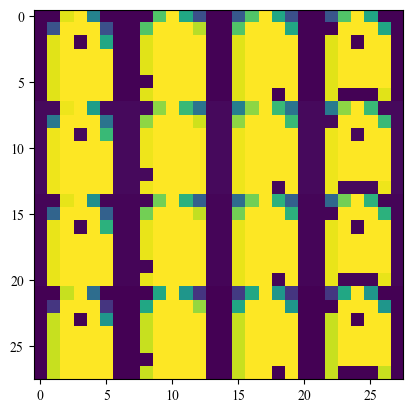

In [194]:
img = train_dataset[567][0].reshape((image_size, image_size)).cpu()

plt.imshow(img)

In [ ]:

EPOCHS = 300
learning_rate = 0.0005
# learning_rate = 1e-3

# model = ResourceRichReadoutLayer(number_of_devcies).to(device=device)
model = ResourceConstraintedReadoutLayer(number_of_devcies*4).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
precision = Precision(task="multiclass", num_classes=10, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=10, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)


In [196]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [1/300], Loss: 1.2653 Validation - Accuracy: 0.5048 Precision: 0.5049  Recall: 0.5048 F1 Score: 0.4329
Epoch [2/300], Loss: 1.1414 Validation - Accuracy: 0.6018 Precision: 0.6765  Recall: 0.6018 F1 Score: 0.5665
Epoch [3/300], Loss: 1.0050 Validation - Accuracy: 0.6507 Precision: 0.6893  Recall: 0.6507 F1 Score: 0.6262
Epoch [4/300], Loss: 0.9149 Validation - Accuracy: 0.6694 Precision: 0.7055  Recall: 0.6694 F1 Score: 0.6497
Epoch [5/300], Loss: 0.9173 Validation - Accuracy: 0.6764 Precision: 0.7159  Recall: 0.6764 F1 Score: 0.6591
Epoch [6/300], Loss: 0.8077 Validation - Accuracy: 0.6776 Precision: 0.7108  Recall: 0.6776 F1 Score: 0.6626
Epoch [7/300], Loss: 0.8672 Validation - Accuracy: 0.6967 Precision: 0.7228  Recall: 0.6967 F1 Score: 0.6829
Epoch [8/300], Loss: 0.8311 Validation - Accuracy: 0.6996 Precision: 0.7236  Recall: 0.6996 F1 Score: 0.6835
Epoch [9/300], Loss: 0.8082 Validation - Accuracy: 0.6940 Precision: 0.7220  Recall: 0.6940 F1 Score: 0.6756
Epoch [10/300], Los

In [197]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.4f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1*100:.4f}')

        

Test Accuracy: 73.9600%
Test Precision: 78.1889%
Test Recall: 73.9600%
Test F1 Score: 71.2113


C:\Users\adith\AppData\Local\Temp\ipykernel_27296\2454491615.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


In [198]:
x = np.argmax(val_fscore)
print(f"Accuracy = {val_accuracy[x]:.5f}\nPrecision = {val_precision[x]:.5f}\nRecall = {val_recall[x]:.5f}\nF-score = {val_fscore[x]:.5f}")
# print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

Accuracy = 0.74890
Precision = 0.78235
Recall = 0.74890
F-score = 0.72266


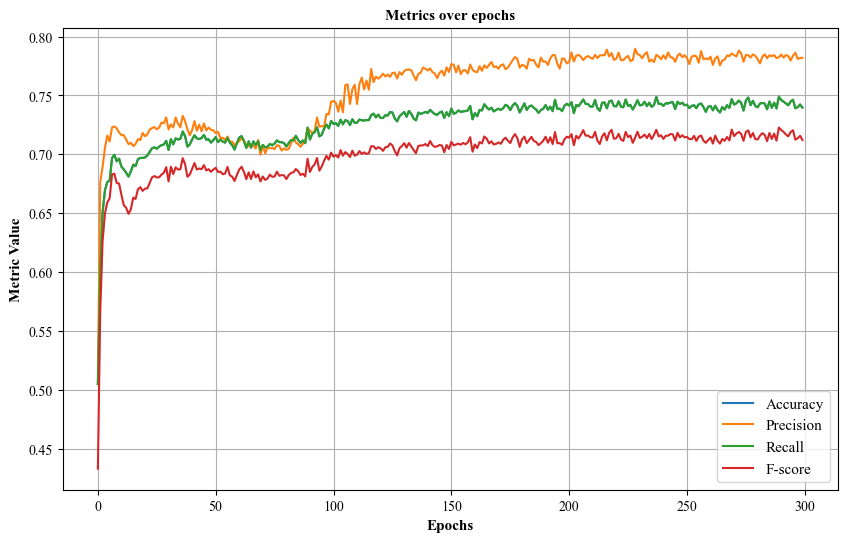

In [199]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [200]:
metrics_df = pd.DataFrame({
    "Accuracy":val_accuracy[::2],
    "Precision":val_precision[::2],
    "Recall":val_recall[::2],
    "F-score":val_fscore[::2]
})

In [201]:
# metrics_path = "./data/MOS2_metrics/FashionMNIST/"

metrics_path = f"./data/MOS2_Results_V2/d2d_{variations}/Fashion_MNIST/"

In [202]:
metrics_path

'./data/MOS2_Results_V2/d2d_10/Fashion_MNIST/'

In [203]:
metrics_df

,Accuracy,Precision,Recall,F-score
0,0.5048,0.504940,0.5048,0.432897
1,0.6507,0.689307,0.6507,0.626152
2,0.6764,0.715900,0.6764,0.659146
3,0.6967,0.722782,0.6967,0.682919
4,0.6940,0.722015,0.6940,0.675593
...,...,...,...,...
145,0.7460,0.784773,0.7460,0.720700
146,0.7432,0.784291,0.7432,0.716835
147,0.7448,0.779651,0.7448,0.718895
148,0.7391,0.786258,0.7391,0.712373


In [204]:
test_confusion_matrix

tensor([[709,  30,  72, 121,   4,   9,  45,   1,   9,   0],
        [  0, 931,  31,  36,   0,   0,   1,   0,   1,   0],
        [ 11,   1, 937,  16,   3,   0,  30,   0,   2,   0],
        [ 17,  58,  46, 867,   1,   0,   9,   0,   2,   0],
        [  0,   8, 754,  98,  39,   0,  98,   0,   3,   0],
        [  0,   0,   1,   0,   0, 861,   0,  80,   1,  57],
        [152,  15, 347,  96,   3,   3, 365,   0,  18,   1],
        [  0,   0,   0,   0,   0,  10,   0, 898,   0,  92],
        [ 16,   4,  54,  35,   1,  11,  18,   8, 849,   4],
        [  1,   0,   0,   1,   0,  16,   0,  40,   2, 940]], device='cuda:0')

In [ ]:

confusion_matrix_df = pd.DataFrame(test_confusion_matrix.cpu().numpy(), index=mnist_data_train.classes, columns=mnist_data_train.classes)


# metrics_df.to_excel(metrics_path+"metrics.xlsx")
# confusion_matrix_df.to_excel(metrics_path + "confusion_matrix.xlsx")